In [1]:
import torch
from torch import nn
torch.__version__

'2.2.1+cu121'

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
# getting the food101 subset (3 food classes and 10% of the actual images )

import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
image_path = data_path/ "pizza_steak_sushi"

if image_path.is_dir():
  print(f"{image_path} already exist")
else:
  image_path.mkdir(parents=True, exist_ok=True)
# ownloading the data

with open(data_path/"pizza_skeak_sushi.zip","wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading the data")
  f.write(request.content)
with zipfile.ZipFile(data_path/"pizza_skeak_sushi.zip","r") as zip_ref:
  zip_ref.extractall(image_path)

In [4]:
# becoming one with the data
# data exploration
import os
def walk_through_dir(dir_path):
  """Walks through dir_path, returning it's content"""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

In [5]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'


In [6]:
# setting up training and testing path
train_dir = image_path/"train"
test_dir = image_path/"test"

In [7]:
# image visulaization
# getting all the image paths using the Path()

import random
from PIL import Image

# random.seed(42)

# getting all the image paths
image_paths_list = list(image_path.glob("*/*/*.jpg"))
random_image_path = random.choice(image_paths_list)

image_class = random_image_path.parent.stem
image_class

'sushi'

Random image path: data/pizza_steak_sushi/test/sushi/2394442.jpg
Image class: sushi
Image height: 408
Image width: 512


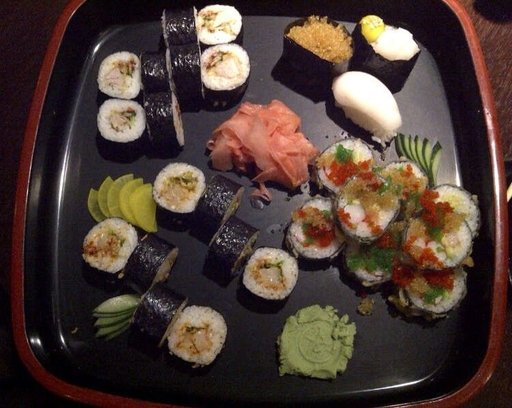

In [8]:
img = Image.open(random_image_path)
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

In [9]:
# visulaization attempt with matplotlib and numpy
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

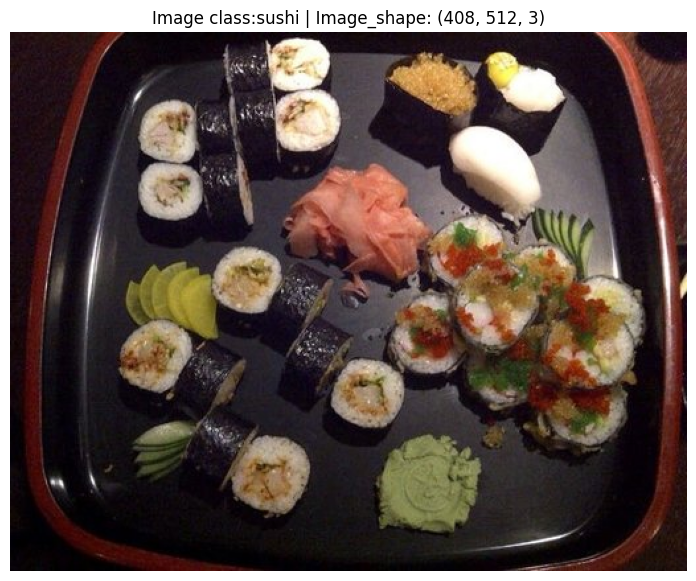

In [10]:
# convert the pil image to a numpy array
img_np = np.asarray(img)
plt.figure(figsize=(10,7))
plt.imshow(img_np)
plt.axis(False)
plt.title(f"Image class:{image_class} | Image_shape: {img_np.shape}")
plt.show()


In [11]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [12]:
# transforming data with torch vision transform
data_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

In [13]:
data_transform(img).shape

torch.Size([3, 64, 64])

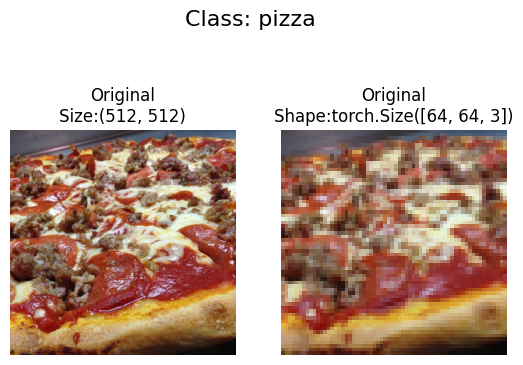

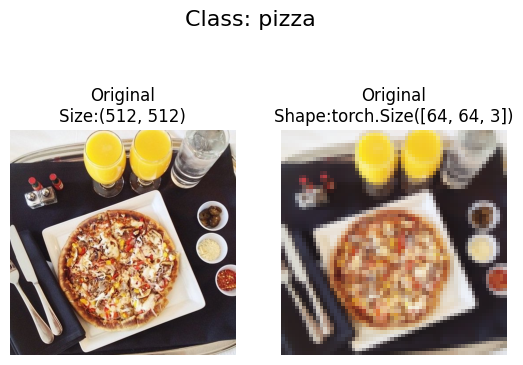

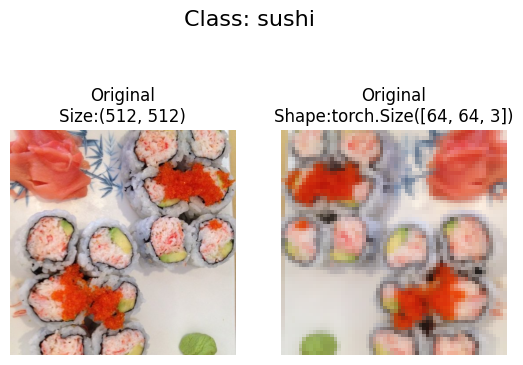

In [14]:
def plot_transformed_images(image_paths:list, transform, n=3, seed=42):
  """Selects random images from paths of images and transforms them and then plots the original and transformed
  """
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths,k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize:{f.size}")
      ax[0].axis(False)

      transformed_image = transform(f).permute(1,2,0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Original\nShape:{transformed_image.shape}")
      ax[1].axis(False)

      fig.suptitle(f'Class: {image_path.parent.stem}',fontsize=16)

plot_transformed_images(image_paths=image_paths_list, transform=data_transform)


## One method of loading the image data from the file *Ie* using the `ImageFolder` from the pytorch site
we can load the image classification data using `torchvision.datasets.ImageFolder`

In [15]:
from torchvision import datasets
train_data = datasets.ImageFolder(root = train_dir,
                                  transform = data_transform,
                                  target_transform = None
                                  )
test_data = datasets.ImageFolder(root = test_dir,
                                 transform = data_transform,
                                 target_transform = None
                                 )
train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [16]:
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [17]:
# processin on the training data
img, label = train_data[0]
print(f'Image shape: {img.shape}')
print(f'Image dtype: {img.dtype}')
print(f"Image Label: {label}" )
print(f"Label dtype: {type(label)}")

Image shape: torch.Size([3, 64, 64])
Image dtype: torch.float32
Image Label: 0
Label dtype: <class 'int'>


Original shape:torch.Size([3, 64, 64])-> [color_channels, height, width]
Image Permute: torch.Size([64, 64, 3])->[height,width, color channels]


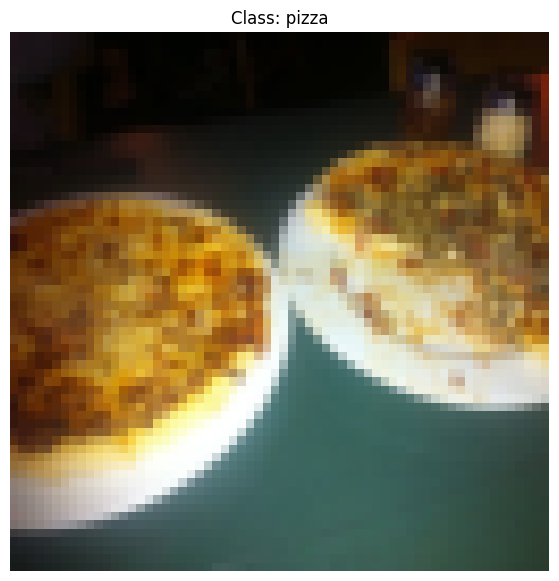

In [18]:
# plotting the data
image_permute = img.permute(1,2,0)
print(f"Original shape:{img.shape}-> [color_channels, height, width]")
print(f"Image Permute: {image_permute.shape}->[height,width, color channels]")

plt.figure(figsize=(10,7))
plt.imshow(image_permute)
plt.title(f'Class: {class_names[label]}')
plt.axis("off")
plt.show()

In [19]:
import os
os.cpu_count()

2

In [20]:
# creating the dataloader
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data,
                              batch_size=32,
                              shuffle=True,
                              num_workers=1

                              )
test_dataloader = DataLoader(test_data,
                              batch_size=32,
                              shuffle=False,
                              num_workers=1
                             )

In [21]:
# loading images data with a custom dataset
import os
import pathlib
import torch
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [22]:
# instance if torch vision.datasets.Imagefolder
# creating heaper function to get class names
# setting

target_directory = train_dir
print(f"Target dir: {target_directory}")
class_names_fount = sorted([entry.name for entry in list(os.scandir(target_directory)) ])
class_names

Target dir: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [23]:
def find_classes(directory:str)->Tuple[List[str], Dict[str, int]]:
  """FInds the class folder names in a target directory. """
  # get the classnames by scannung the ditectory
  classes= sorted(entry.name for entry in os.scandir(target_directory) if entry.is_dir())
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}... please check the file structure.")
  # creating dixtionary of index labels
  class_to_idx  = {class_name:i for i, class_name in enumerate(classes)}
  return classes, class_to_idx

find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [24]:
# creating a custom dataset to imitate ImageFolder

from torch.utils.data import Dataset

class ImageFolderCustom(Dataset):
  def __init__(self,target_dir:str, transform=None):
    # getting all the files in the provided path to handle the extraction of jpeg file
    self.paths = list(pathlib.Path(target_dir).glob("*/*.jpg"))
    # transforms handle the functions to manupulate the files and make them to the desired format
    self.transform = transform
    # the extraction of the available classes
    self.classes, self.class_to_idx = find_classes(target_dir)
  def load_image(self, index:int)->Image.Image:
    """Opens an image via a path and returns it."""
    image_path = self.paths[index]
    return Image.open(image_path)
  # overriding the lenght of the dataset
  def __len__(self)->int:
    return len(self.paths)
  # override the get item method for specific sample return
  def __getitem__(self, index:int)->Tuple[torch.Tensor, int]:
    """Returns one sample of data, data and label (X,y)."""
    img = self.load_image(index)
    class_name = self.paths[index].parent.name
    class_idx = self.class_to_idx[class_name]
    if self.transform:
      return self.transform(img), class_idx
    return img, class_idx


In [25]:
from torchvision import transforms
train_transforms = transforms.Compose([transforms.Resize(size=(64,64)),
                                       transforms.RandomHorizontalFlip(p=0.5),
                                       transforms.ToTensor()
                                       ])
test_transforms = transforms.Compose([transforms.Resize(size=(64,64)),
                                      #  transforms.RandomHorizontalFlip(p=0.5),
                                       transforms.ToTensor()
                                       ])


In [26]:
# testing image foler custom

train_data_custom = ImageFolderCustom(target_dir = train_dir,
                                      transform=train_transforms)
test_data_custom = ImageFolderCustom(target_dir = test_dir,
                                      transform=test_transforms)


In [27]:
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7c0cf1ba6b90>,
 <__main__.ImageFolderCustom at 0x7c0cf1ba7310>)

In [28]:
len(train_data), len(train_data_custom)

(225, 225)

In [29]:
len(test_data), len(test_data_custom)

(75, 75)

In [30]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [31]:
# check for equality
print(f"{train_data_custom.classes==train_data.classes}")
print(f"{test_data_custom.classes==test_data.classes}")

True
True


In [32]:
# data visualization from a random sample of the data
import random
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes:List[str]=None,
                          n:int=10,
                          display_shape:bool=True,
                          seed:int=None
                          ):
  if n> 10:
    n = 10
    display_shape=False,
    print(f'For display purposes, n ({n}) shoulf not be greater than 10, Value automatically set to 10')
  if seed:
    random.seed(seed)
  # get random sample indexes
  plt.figure(figsize=(16,8))
  random_sample_idx = random.sample(range(len(dataset)),k=n)
  for i, target_sample in enumerate(random_sample_idx):
    targ_img, targ_label = dataset[target_sample]
    # plotting the sample
    plt.subplot(1,n,i+1)
    plt.imshow(targ_img.permute(1,2,0))
    plt.axis("off")
    title = ''
    if classes:
      title =f"Class: {classes[targ_label]}"
      if display_shape:
        title = title+f"\nshape:{targ_img.permute(1,2,0).shape}"
    plt.title(title)




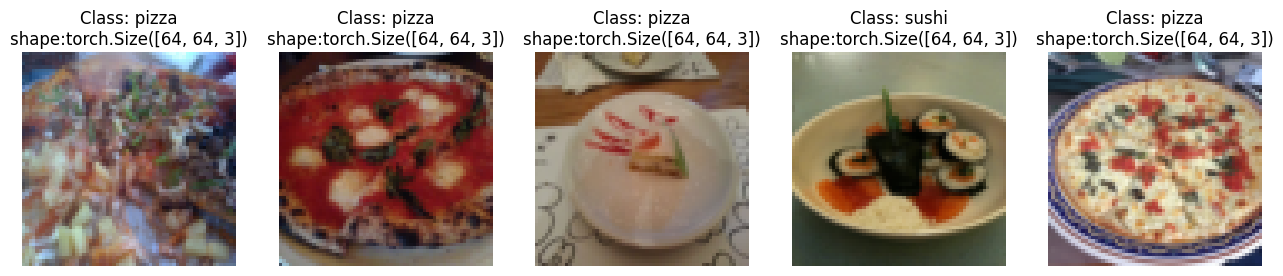

In [33]:
# displauing the random images
len(train_data)
display_random_images(dataset = train_data,classes = class_names,n=5,seed=None)

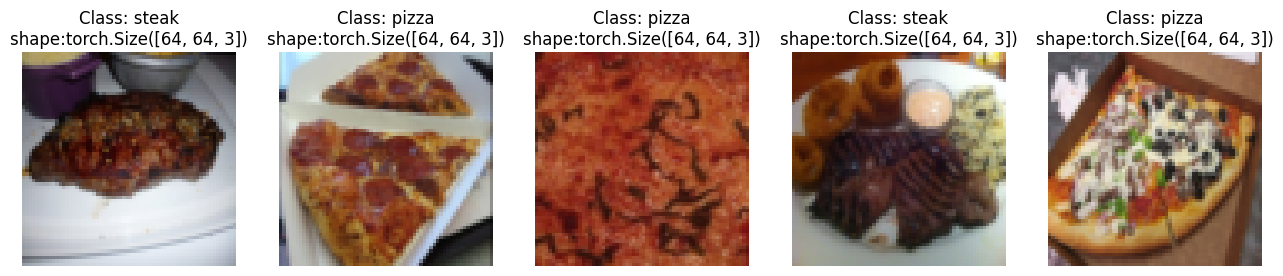

In [34]:
# siaplaying random images from my custom dataset
display_random_images(dataset = train_data_custom,classes = class_names,n=5,seed=42)

In [35]:
# passign custom loaded data into the dataloader
from torch.utils.data import DataLoader
BATCH_SIZE = 32

train_dataloader_custom = DataLoader(train_data_custom,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=0
                              )
train_dataloader_custom = DataLoader(test_data_custom,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=0
                              )

In [36]:
# get image and label from dataloader
img_custom, label_custom = next(iter(train_dataloader_custom))
img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [37]:
# working with other forms of data augmentation
# looking at trivial augment
from torchvision import transforms
train_transforms_t = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins = 31),
    transforms.ToTensor()
])

In [38]:
image_path_lst = list(image_path.glob("*/*/*.jpg"))
image_path_lst[:10]

[PosixPath('data/pizza_steak_sushi/train/pizza/2885050.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/320570.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/1968947.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/3505182.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/5764.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/2760984.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/2451169.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/786995.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/702165.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/741883.jpg')]

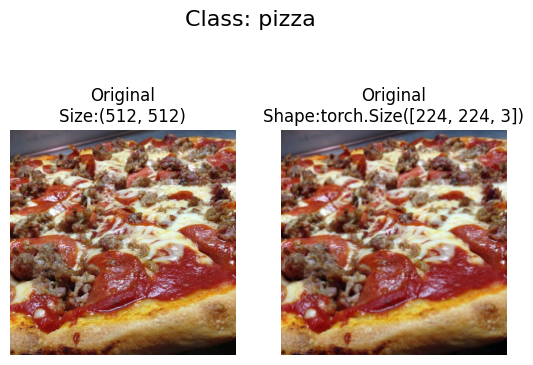

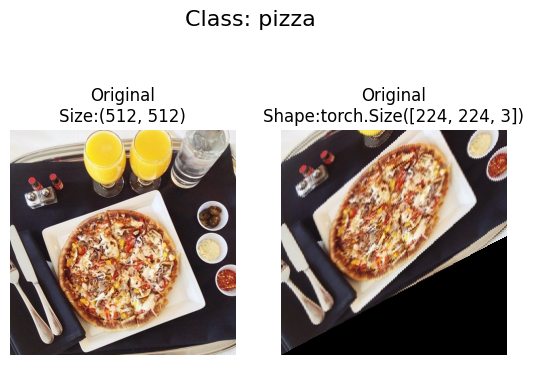

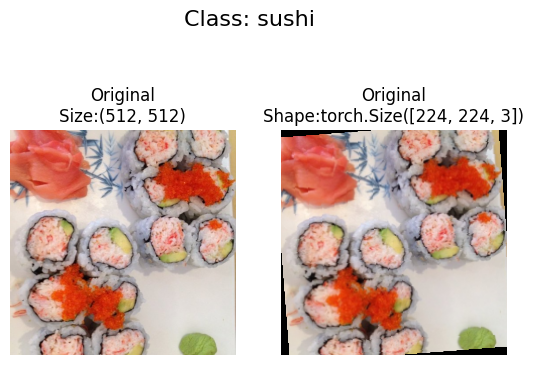

In [39]:
plot_transformed_images(image_path_lst,
                        transform=train_transforms_t
                        )

In [40]:
# building the baseline model
# replicatint the tiny vgg
# creating simple transform now simple_transforms
simple_transform = transforms.Compose([ transforms.Resize(size=(64,64)),
                                       transforms.ToTensor()])

In [41]:
from torchvision import datasets


train_data_m0 = datasets.ImageFolder(root=train_dir,
                                     transform=simple_transform,
                                     target_transform=None)
test_data_m0 = datasets.ImageFolder(root=test_dir,
                                    transform=simple_transform,
                                    target_transform=None
                                    )

In [42]:
from torch.utils.data import DataLoader
BATCH_SIZE=32
train_dataloader_m0 = DataLoader(train_data_m0,batch_size=BATCH_SIZE,shuffle=True)
test_dataloader_m0 =DataLoader(test_data_m0,batch_size=BATCH_SIZE,shuffle=False)

In [73]:
class TinyVGG(nn.Module):
  def __init__(self, input_shape:int, hidden_units:int,output_shape:int):
    super().__init__()
    self.layer_1 = nn.Sequential(
        nn.Conv2d(in_channels = input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
          nn.Conv2d(in_channels = hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                         stride=2),
    )
    self.layer_2 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
          nn.Conv2d(in_channels = hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                         stride=2),
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(hidden_units*13*13,
                  output_shape)
    )

  def forward(self, x):
    x = self.layer_1(x)
    # print(x.shape)
    x = self.layer_2(x)
    # print(x.shape)
    x = self.classifier(x)
    # print(x.shape)
    return x

In [104]:
torch.manual_seed(42)
model_0 = TinyVGG(3,10,len(class_names)).to(device)

model_0

TinyVGG(
  (layer_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [105]:
# testing the forward pass to getm the hidden dimansions misalignment image

image_batch, label_batch  = next(iter(train_dataloader_m0))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [106]:
try:
  import torchinfo
except:
  !pip install torchinfo -q
  import torchinfo
from torchinfo import summary
summary(model = model_0, input_size=image_batch.shape)

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 3]                   --
├─Sequential: 1-1                        [32, 10, 30, 30]          --
│    └─Conv2d: 2-1                       [32, 10, 62, 62]          280
│    └─ReLU: 2-2                         [32, 10, 62, 62]          --
│    └─Conv2d: 2-3                       [32, 10, 60, 60]          910
│    └─ReLU: 2-4                         [32, 10, 60, 60]          --
│    └─MaxPool2d: 2-5                    [32, 10, 30, 30]          --
├─Sequential: 1-2                        [32, 10, 13, 13]          --
│    └─Conv2d: 2-6                       [32, 10, 28, 28]          910
│    └─ReLU: 2-7                         [32, 10, 28, 28]          --
│    └─Conv2d: 2-8                       [32, 10, 26, 26]          910
│    └─ReLU: 2-9                         [32, 10, 26, 26]          --
│    └─MaxPool2d: 2-10                   [32, 10, 13, 13]          --
├─Sequentia

In [107]:
from tqdm.auto import tqdm

In [111]:
# creating the training step
def train_step(model:torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               accuracy_fn,
               device:torch.device=device)->Tuple[float, float]:
  """The function is for the training which handles the whole """
  loss, accuracy = 0,0
  model.to(device)
  model.train()
  for X,y in dataloader:
    X,y = X.to(device),y.to(device)
    # model.train()
    y_pred = model(X)
    temp_loss = loss_fn(y_pred,y)
    loss +=temp_loss.item()
    accuracy +=accuracy_fn(y,
                           y_pred.argmax(dim=1))
    optimizer.zero_grad()
    temp_loss.backward()
    optimizer.step()
  loss /=len(dataloader)
  accuracy /=len(dataloader)
  return loss,accuracy

  # building the test_step

def test_step(model:torch.nn.Module,
              dataloader:torch.utils.data.DataLoader,
              loss_fn:torch.nn.Module,
              accuracy_fn,
              device:torch.device=device)->Tuple[float,float]:
  """The function works bu checking the test data"""
  loss, accuracy = 0,0
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for X,y in dataloader:
      X,y = X.to(device),y.to(device)
      y_pred = model(X)
      loss +=loss_fn(y_pred,y).item()
      accuracy +=accuracy_fn(y,
                            y_pred.argmax(dim=1))
    loss /=len(dataloader)
    accuracy /=len(dataloader)
  return loss,accuracy

In [109]:
# importing the helper functions
import requests
from pathlib import Path

# downloading pytorch helper funrtions to colab if not already available

if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Download helper_functions.py")
  request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
  with open("helper_functions.py", 'wb') as f:
    f.write(request.content)

helper_functions.py already exists, skipping download


In [92]:
from helper_functions import accuracy_fn

In [126]:
# building the training loop
def train_function(model:torch.nn.Module,
                   train_dataloader:torch.utils.data.DataLoader,
                   test_dataloader:torch.utils.data.DataLoader,
                   loss_fn:torch.nn.Module,
                   optimizer:torch.optim.Optimizer,
                   accuracy_fn,
                   epochs:int,
                   device:torch.device=device,
                   )->Dict[str, List[float]]:
  results = {"train_loss":[],
             "train_acc":[],
             "test_acc":[],
             "test_loss":[]}
  for epoch in tqdm(range(epochs)):
    train_loss, train_accuracy = train_step(model=model,
                            dataloader=train_dataloader,
                            loss_fn=loss_fn,
                            optimizer = optimizer,
                            accuracy_fn=accuracy_fn,
                            device=device)
    test_loss, test_accuracy = test_step(model=model,
                                        dataloader=test_dataloader,
                                        accuracy_fn=accuracy_fn,
                                        loss_fn = loss_fn,
                                        device = device)
    results["train_loss"].append(train_loss)
    results["test_loss"].append(test_loss)
    results["train_acc"].append(train_accuracy)
    results["test_acc"].append(test_accuracy)
    print(f"Epoch:{epoch}|Train Loss: {train_loss:.5f}| Train Accuracy: {train_accuracy:.2f}%| Test Loss: {test_loss:.5f}| Test Accuracy: {test_accuracy:.2f}%")
  return results



In [181]:
# creating the loss and optimizer functions
torch.manual_seed(42)
model_0 = TinyVGG(3,10,len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),lr=0.001)

In [182]:
# calling the train function
epochs = 10
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer
start_time = timer()
res_m0 = train_function(model=model_0,
              train_dataloader=train_dataloader_m0,
              test_dataloader=test_dataloader_m0,
              loss_fn=loss_fn,
              optimizer = optimizer,
              accuracy_fn=accuracy_fn,
              device=device,
               epochs=epochs)
end_time = timer()
end_time-start_time

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:0|Train Loss: 1.10354| Train Accuracy: 25.00%| Test Loss: 1.09935| Test Accuracy: 26.04%
Epoch:1|Train Loss: 1.07612| Train Accuracy: 42.58%| Test Loss: 1.12996| Test Accuracy: 26.04%
Epoch:2|Train Loss: 1.07241| Train Accuracy: 42.58%| Test Loss: 1.16222| Test Accuracy: 26.04%
Epoch:3|Train Loss: 1.10990| Train Accuracy: 30.47%| Test Loss: 1.15158| Test Accuracy: 27.08%
Epoch:4|Train Loss: 1.08344| Train Accuracy: 35.55%| Test Loss: 1.14957| Test Accuracy: 23.96%
Epoch:5|Train Loss: 1.08627| Train Accuracy: 41.80%| Test Loss: 1.13286| Test Accuracy: 31.25%
Epoch:6|Train Loss: 0.99345| Train Accuracy: 57.42%| Test Loss: 1.12070| Test Accuracy: 28.12%
Epoch:7|Train Loss: 0.99490| Train Accuracy: 53.12%| Test Loss: 1.06429| Test Accuracy: 31.16%
Epoch:8|Train Loss: 0.98729| Train Accuracy: 46.48%| Test Loss: 1.02238| Test Accuracy: 35.13%
Epoch:9|Train Loss: 0.87622| Train Accuracy: 49.61%| Test Loss: 0.93832| Test Accuracy: 56.63%


21.923915395000222

In [165]:
def plot_loss_curve(results:Dict[str,List[float]]):
  """Plotting training curves of a results dictionary."""
  #get the loss values of the results dict
  loss, test_loss = results["train_loss"], results["test_loss"]
  acc, test_acc = results["train_acc"], results["test_acc"]

  epochs = range(len(results["train_loss"]))
  plt.figure(figsize=(15,7))
  plt.subplot(1,2,1)
  plt.plot(epochs,loss,label="Train_loss")
  plt.plot(epochs,test_loss,label="Test_loss")
  plt.title("Loss")
  plt.xlabel("epochs")
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(epochs,acc,label="train_accuracy")
  plt.plot(epochs,test_acc,label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("epochs")
  plt.legend()

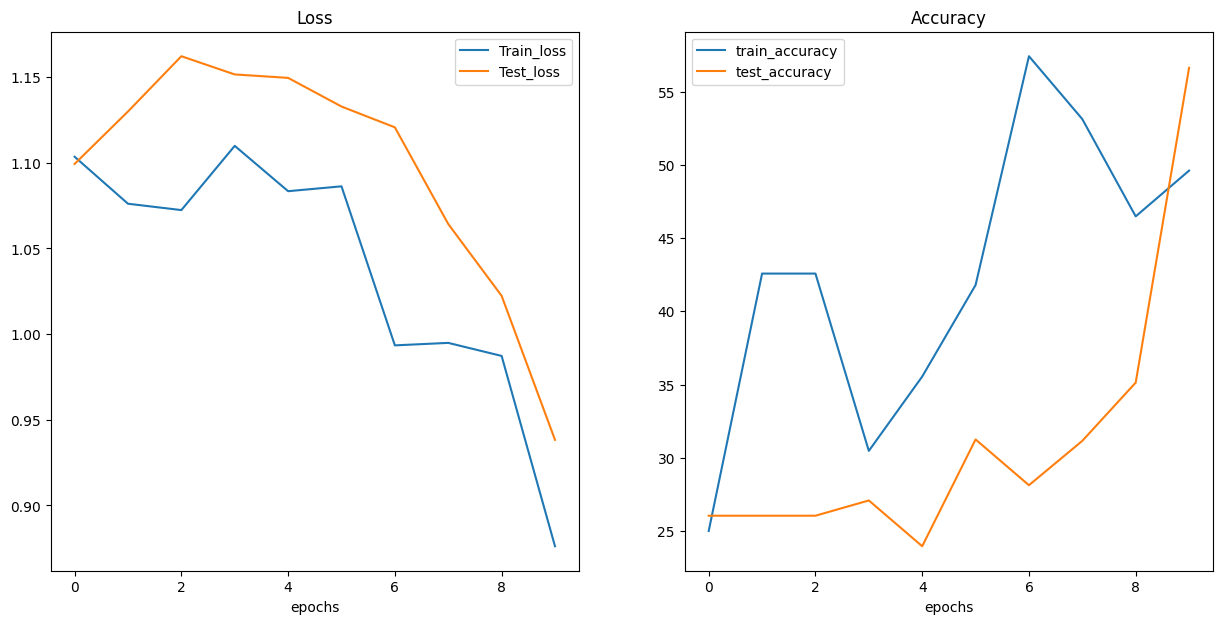

In [183]:
plot_loss_curve(res_m0)

In [173]:
# Implementing Tiny vgg with Data augmentation '

train_transforms_trivial = transforms.Compose([
  transforms.Resize(size=(64,64)),
  transforms.TrivialAugmentWide(num_magnitude_bins=31),
  transforms.ToTensor()
])

test_tranforms_simple = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])


In [174]:
# turning image folders to datasts
from torchvision import datasets
from torch.utils.data import DataLoader
train_data_augnemted = datasets.ImageFolder(root=train_dir,
                                            transform=train_transforms_trivial)
test_data_simple = datasets.ImageFolder(root = test_dir,
                                        transform = test_tranforms_simple)


In [175]:
import os
BATCH_SIZE=32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)

train_dataloader_augmented = DataLoader(
    dataset = train_data_augnemted,
    batch_size = BATCH_SIZE,
    shuffle=True,
    num_workers = NUM_WORKERS
)
test_dataloader_simple = DataLoader(dataset = test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS
                                    )

In [185]:
# performing the train operation
torch.manual_seed(42)
model_1 = TinyVGG(3,10,len(class_names))
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr = 1e-3)

In [186]:
epochs = 10
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer
start_time = timer()
res_m1 = train_function(model=model_1,
              train_dataloader=train_dataloader_augmented,
              test_dataloader=test_dataloader_simple,
              loss_fn=loss_fn,
              optimizer = optimizer,
              accuracy_fn=accuracy_fn,
              device=device,
               epochs=epochs)
end_time = timer()
end_time-start_time

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:0|Train Loss: 1.10491| Train Accuracy: 25.00%| Test Loss: 1.10193| Test Accuracy: 26.04%
Epoch:1|Train Loss: 1.08069| Train Accuracy: 42.58%| Test Loss: 1.12606| Test Accuracy: 26.04%
Epoch:2|Train Loss: 1.07117| Train Accuracy: 42.58%| Test Loss: 1.15927| Test Accuracy: 26.04%
Epoch:3|Train Loss: 1.12531| Train Accuracy: 30.47%| Test Loss: 1.15807| Test Accuracy: 26.04%
Epoch:4|Train Loss: 1.08653| Train Accuracy: 42.58%| Test Loss: 1.15543| Test Accuracy: 33.33%
Epoch:5|Train Loss: 1.08564| Train Accuracy: 38.28%| Test Loss: 1.14327| Test Accuracy: 28.12%
Epoch:6|Train Loss: 1.06648| Train Accuracy: 50.00%| Test Loss: 1.12783| Test Accuracy: 29.17%
Epoch:7|Train Loss: 1.08106| Train Accuracy: 34.77%| Test Loss: 1.11051| Test Accuracy: 30.21%
Epoch:8|Train Loss: 1.08337| Train Accuracy: 42.19%| Test Loss: 1.10172| Test Accuracy: 32.29%
Epoch:9|Train Loss: 1.00754| Train Accuracy: 54.69%| Test Loss: 0.99004| Test Accuracy: 48.39%


22.220429820998106

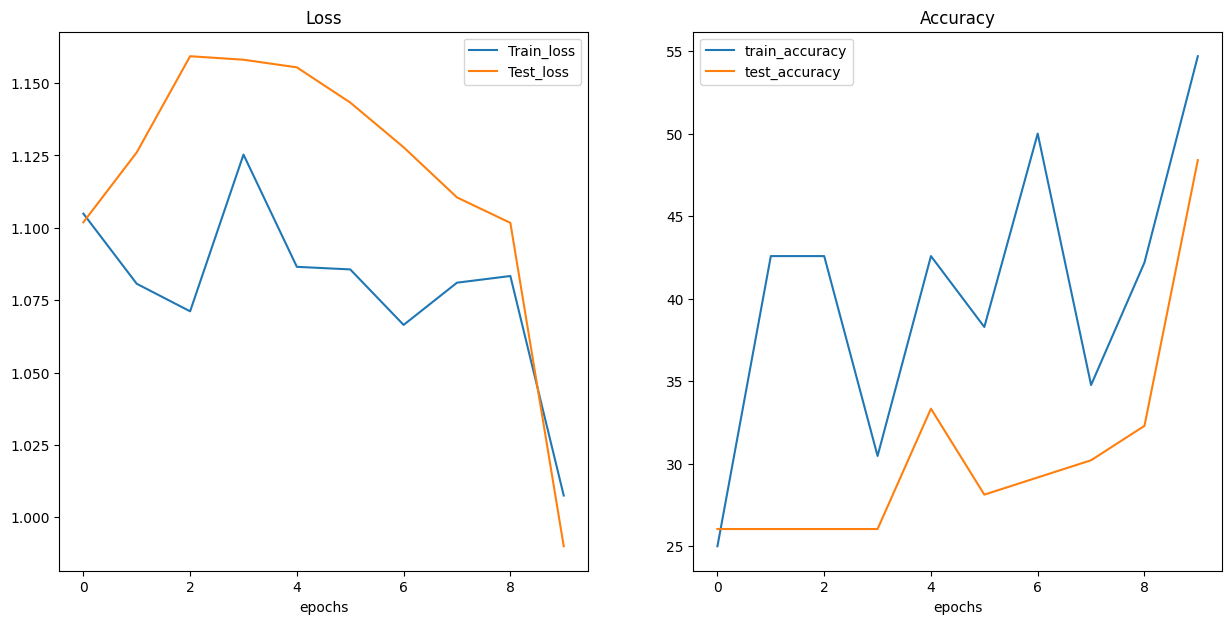

In [187]:
plot_loss_curve(res_m1)

**Useful tools for data monitoring**

After Evaluating modelling experiments on their own, it's important to compare the to each other
Here are some ways to archieve this:
1. Hard Coding(What we're doing)
2. Pytorch + Tensorboard- https://pytorch.org/docs/stable/tensorboard.html
3. Weights & Biases - https://wandb.ai/site/experiment-tracking
4. MLFlow - https://mlflow.org


In [190]:
import pandas as pd
model_0_df = pd.DataFrame(res_m0)
model_1_df = pd.DataFrame(res_m1)
model_0_df

,train_loss,train_acc,test_acc,test_loss
0,1.103543,25.000000,26.041667,1.099349
1,1.076116,42.578125,26.041667,1.129959
2,1.072412,42.578125,26.041667,1.162215
3,1.109901,30.468750,27.083333,1.151580
4,1.083440,35.546875,23.958333,1.149573
5,1.086273,41.796875,31.250000,1.132858
6,0.993453,57.421875,28.125000,1.120701
7,0.994898,53.125000,31.155303,1.064293
8,0.987287,46.484375,35.132576,1.022379
9,0.876218,49.609375,56.628788,0.938319


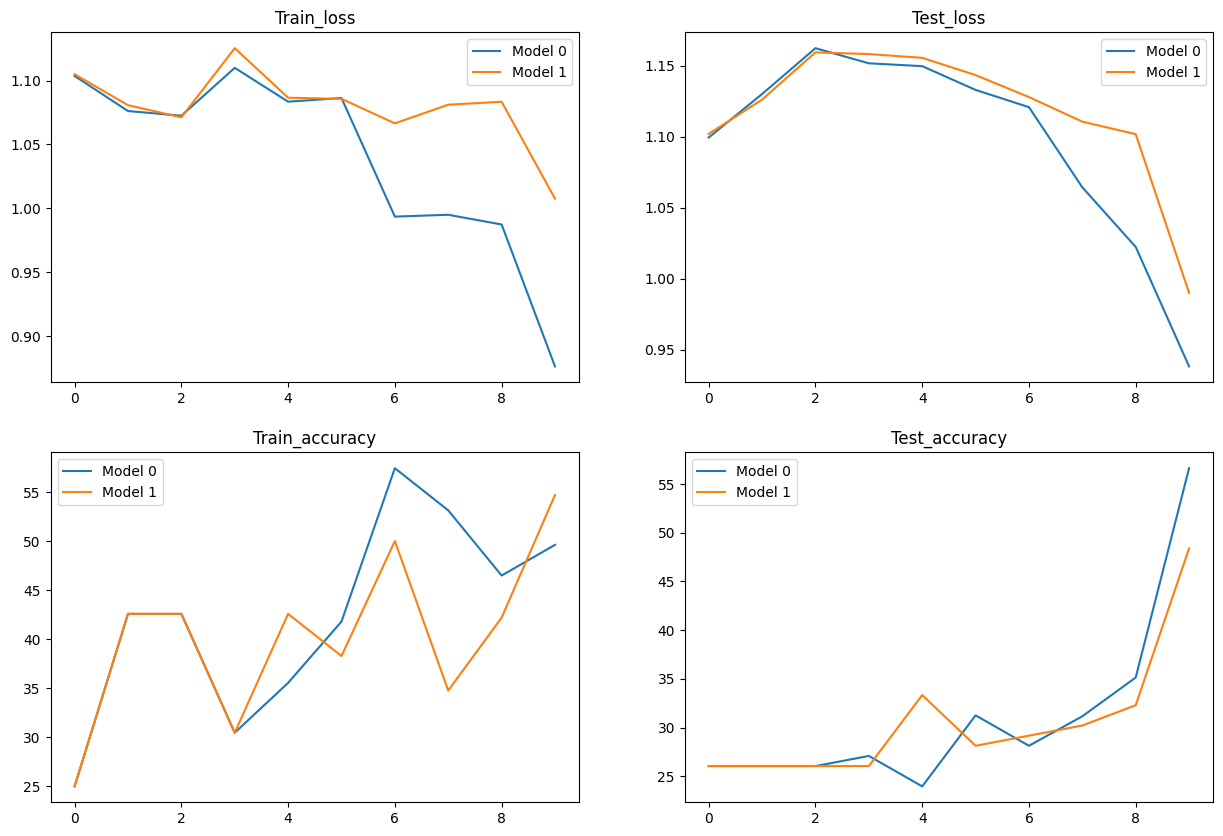

In [191]:
# setting up a plot
plt.figure(figsize=(15,10))
epochs = range(len(model_0_df))

plt.subplot(2,2,1)
plt.plot(epochs, model_0_df["train_loss"],label="Model 0")
plt.plot(epochs, model_1_df['train_loss'],label="Model 1")
plt.title("Train_loss")
plt.legend()
# test_loss
plt.subplot(2,2,2)
plt.plot(epochs, model_0_df["test_loss"],label="Model 0")
plt.plot(epochs, model_1_df['test_loss'],label="Model 1")
plt.title("Test_loss")
plt.legend()

plt.subplot(2,2,3)
plt.plot(epochs, model_0_df["train_acc"],label="Model 0")
plt.plot(epochs, model_1_df['train_acc'],label="Model 1")
plt.title("Train_accuracy")
plt.legend()


plt.subplot(2,2,4)
plt.plot(epochs, model_0_df["test_acc"],label="Model 0")
plt.plot(epochs, model_1_df['test_acc'],label="Model 1")
plt.title("Test_accuracy")
plt.legend()


In [192]:
# making predition of custon data
import requests
custom_image_path = data_path/"04-pizza-dad.jpeg"
if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    # when downloading an image target is making use of the raw link
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
    print(f"Dowloading {custom_image_path}")
    f.write(request.content)
else:
  print(f"{custom_image_path} already Exist")




Dowloading data/04-pizza-dad.jpeg


In [213]:
# working with custom image for model prediction
import torchvision
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))
# print(f"Custom image tensor:\n{}")

(-0.5, 3023.5, 4031.5, -0.5)

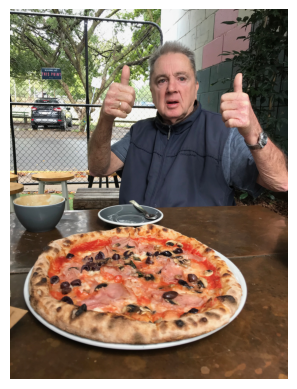

In [214]:
# plotting the output
plt.imshow(custom_image_uint8.permute(1,2,0))
plt.axis("off")

In [215]:
# converting image to flot 32
custom_image_float32 = custom_image_uint8.type(torch.float)/255


In [216]:
# creating transform piprline to hanle predictions
custom_image_transform = transforms.Compose([
    transforms.Resize(size=(64,64))
])

custom_image_transformed = custom_image_transform(custom_image_float32)

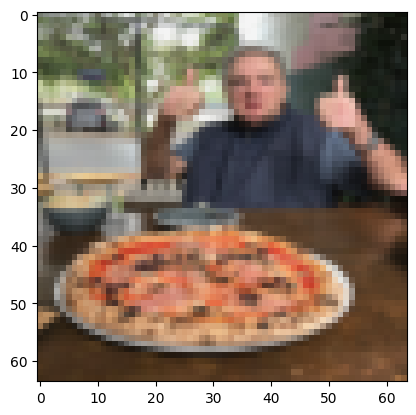

In [217]:
custom_image_transformed.shape
plt.imshow(custom_image_transformed.permute(1,2,0))

In [218]:
model_1.eval()
custom_image_transformed= custom_image_transformed.unsqueeze(dim=0).to(device)
with torch.inference_mode():
  custom_image_pred = model_1(custom_image_transformed)

class_name = custom_image_pred.argmax(dim=1)

name = class_names[class_name]
print(name)


pizza


None


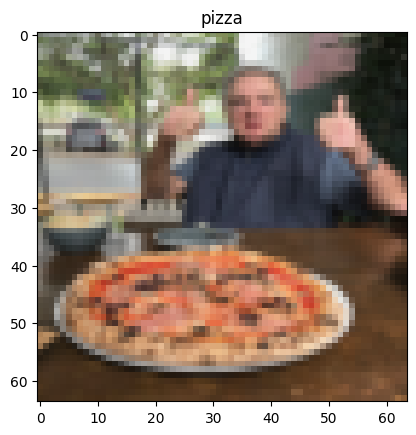

In [232]:
# building prediction function
def precitct_class(path, model,class_names,transform,device)->str:
  image = torchvision.io.read_image(str(path)).type(torch.float).to(device).unsqueeze(0)/255
  transformed_image = transform(image)
  model.eval()
  model.to(device)
  with torch.inference_mode():
    y_logit = model(transformed_image)
    pred_probs =torch.softmax(y_logit,dim=1)
    pred_class =  torch.argmax(pred_probs,dim=1)

  plt.imshow(transformed_image.squeeze().permute(1,2,0))
  plt.title(class_names[pred_class.cpu()])

custom_image_transform = transforms.Compose([
  transforms.Resize(size=(64,64))
])

preditcions = precitct_class(custom_image_path,model_1,class_names,custom_image_transform,device)
print(preditcions)


